In [144]:
import json
import matplotlib.pyplot as plt
import numpy as np
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 4)

import os
from dtw import dtw

cwd = os.getcwd()
print (cwd)
# import mlpy

Populating the interactive namespace from numpy and matplotlib
/accounts/grad/jorothy_gong/MyShakeAnalysis/code/Yun


In [139]:
def get_data(data):
    '''
    helper function to get the timestamp and 3-component acceleration data. 
    '''
    # read in x, y, z data
    x = data['data']['x']
    y = data['data']['y']
    z = data['data']['z']

    # calculate the timestamp
    # get the start time
    t0 = data['header']['starttime']
    npoints = len(x)
    sampling_rate = data['header']['sampling_rate']
    
    # get the end time 
    t1 = t0 + npoints / sampling_rate
    
    # form the timestamp
    t = [t0 + tmp/sampling_rate for tmp in range(0, npoints)]
    
    # station latitude and long
    return t, x, y, z

def plot_data(t, x, y, z):
    '''
    helper function to plot the 3-component acceleration data
    '''
    figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(311)
    plt.plot(t, x)
    plt.subplot(312)
    plt.plot(t, y)
    plt.ylabel('Acceleration (g)')
    plt.subplot(313)
    plt.plot(t, z)
    plt.xlabel('Time (sec)')
    plt.show()

## Read simulated data

1625 1625 25.0


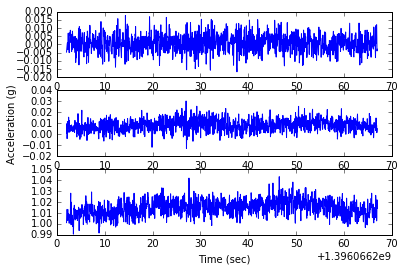

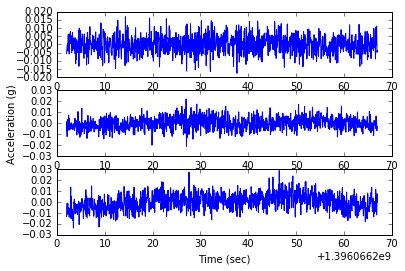

In [129]:
data = json.load(open('../../data/EQ/simulated/12951_M5.1_1396066202.json', 'r'))

t, x, y, z = get_data(data)
rate = data['header']['sampling_rate'];
#print(data['header'])
print (len(x), len(t), rate)
plot_data(t, x, y, z)

x, y, z = Normalize_Seq(x, y, z)
plot_data(t, x, y, z)

## Read shake table data

984 984 25.0


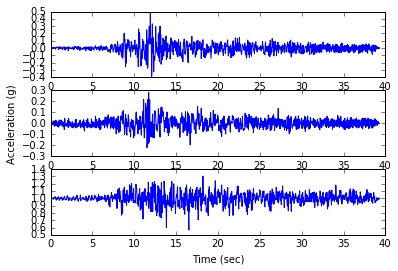

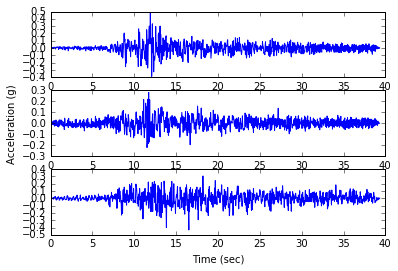

In [133]:
data = json.load(open('../../data/EQ/shake_table/trial142_phone2.json', 'r'))

t, x, y, z = get_data(data)
rate = data['header']['sampling_rate'];
print (len(x), len(t), rate)
plot_data(t, x, y, z)
# from matplotlib.pyplot import specgram
# specgram(z, NFFT=100, Fs=rate, noverlap = 50);

x, y, z = Normalize_Seq(x, y, z)
plot_data(t, x, y, z)

## Read human data

6284 6284 25.0


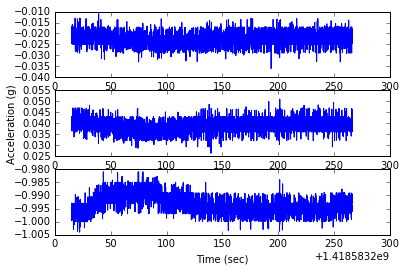

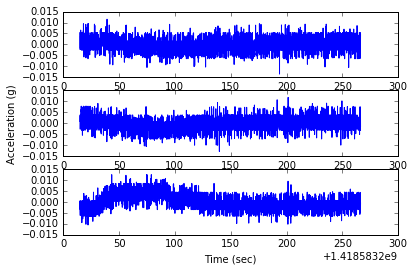

In [135]:
data = json.load(open('../../data/Human/013306004148017_1418583215.json', 'r'))

t, x, y, z = get_data(data)
rate = data['header']['sampling_rate'];
print (len(x), len(t), rate)
plot_data(t, x, y, z)

x, y, z = Normalize_Seq(x, y, z)
plot_data(t, x, y, z)

## Dynamic Time Warping

In [141]:
def Normalize_Seq(seq_x = None, seq_y = None, seq_z = None, dim = 3):
    """
    May need further normalization later.
    Take either 1-dim accelaretion sequence or 3-dim, or 2-idm.
    """
    tmp = []
    if seq_x != None:
        seq_x = seq_x - np.mean(seq_x)
        tmp.append(seq_x)
    if seq_y != None:
        seq_y = seq_y - np.mean(seq_y)
        tmp.append(seq_y)
    if seq_z != None:
        seq_z = seq_z - np.mean(seq_z)
        tmp.append(seq_z)
        
    if dim != 3:
        return tmp
    else:
        return seq_x, seq_y, seq_z

In [145]:
def MyDistance(x, y):
    return (x * x) + (y * y)

def Cal_DTW(x, y, fun = None):
    #print('ha')
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)
    if fun == None:
        dist, cost, acc, path = dtw(x, y, dist = lambda x, y: norm(x - y, ord=1))
    else:
        dist, cost, acc, path = dtw(x, y, dist = fun)
        
    return dist

In [146]:
# Cal_DTW_Compare
def DTW_Self(seq, window = 2, interval = 0.5, gap = 1/5, rate = 25):
    """
    Now sequence is only 1-dim accelaration sequence.
    Add if sequence length < 5 seconds
    """
    seq = seq - np.mean(seq)
    seq_len = len(seq)
    seq_win = int(window * rate)
    seq_int = int(interval * rate)
    compute_gap = int(gap * rate)
    return [Cal_DTW(seq[i : (i + seq_win)], seq[(i + seq_int) : (i + seq_win + seq_int)]) 
            for i in range(0, seq_len - seq_win - seq_int, compute_gap)]
 

In [164]:
path_to_json = cwd + '/../../data/EQ/simulated/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(len(json_files))
json_files = json_files

993


In [ ]:
DTW = {}

for js in json_files:
    print(js)
    with open(path_to_json+js) as infile:
        data = json.load(infile)
      
    t, x, y, z = get_data(data)
    rate = data['header']['sampling_rate']
    x, y, z = Normalize_Seq(x, y, z)
    DTW[js] = {'DTW_x': DTW_Self(seq = x, rate = rate), 
                     'DTW_y': DTW_Self(seq = y, rate = rate), 
                     'DTW_z': DTW_Self(seq = z, rate = rate)}
    
with open(path_to_json + 'DTW_simulated.json', 'w') as f:
    json.dump(DTW, f, indent=None, sort_keys=False)

24987_M5.1_1396066170.json
14004_M5.1_1396066178.json
14036_M5.1_1396066184.json
IWT007_M9.0_1299854806.json
552_M6.4_0.json
IWTH02_M9.0_1299854817.json
J064_M6.0_1408875618.json
IWT010_M9.0_1299854812.json
IBRH16_M9.0_1299854824.json
24853_M5.1_1396066172.json
SZOH33_M6.5_1249967232.json
22078_M5.1_1396066202.json
J065_M6.0_1408875620.json
58349_M6.0_1408875641.json


## Example with interval = 1/2 second

shake


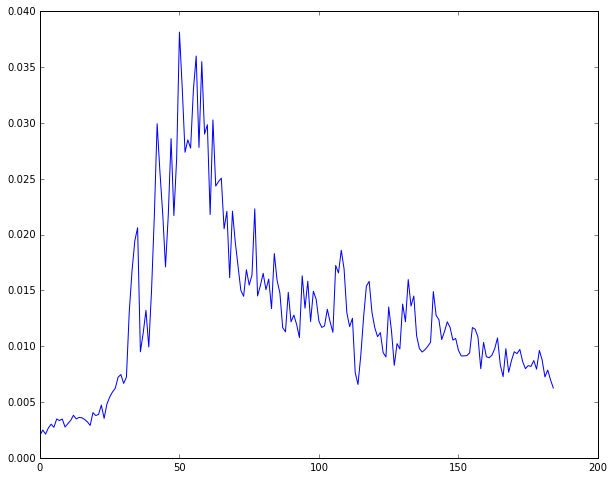

In [134]:
print('shake')
plot(DTW_Self(x))

simulated


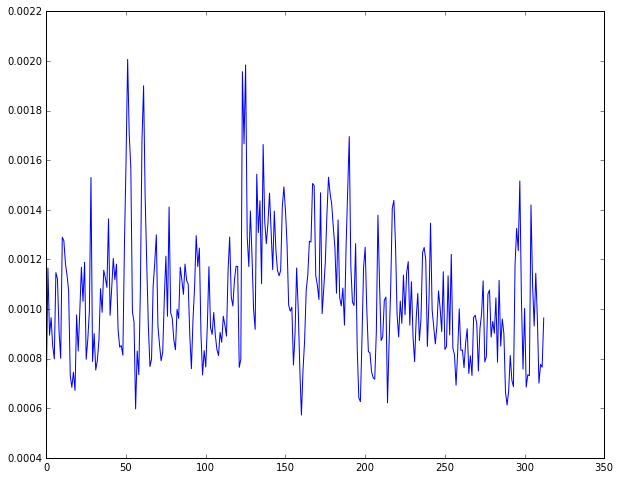

In [132]:
print("simulated")
plot(DTW_Self(x))

human


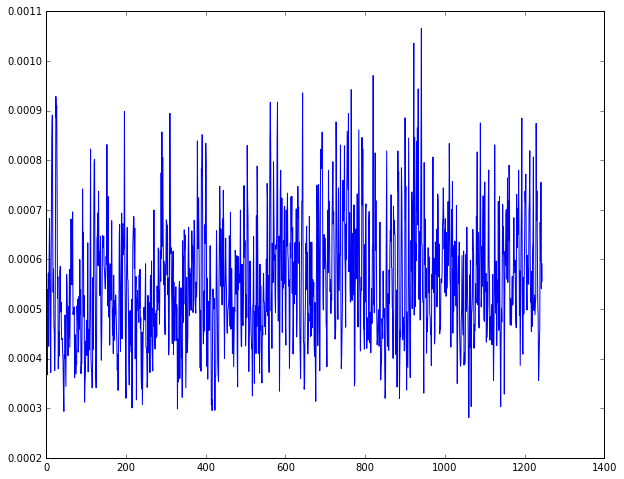

In [136]:
print("human")
plot(DTW_Self(x))

## Example with interval = 1/25 second

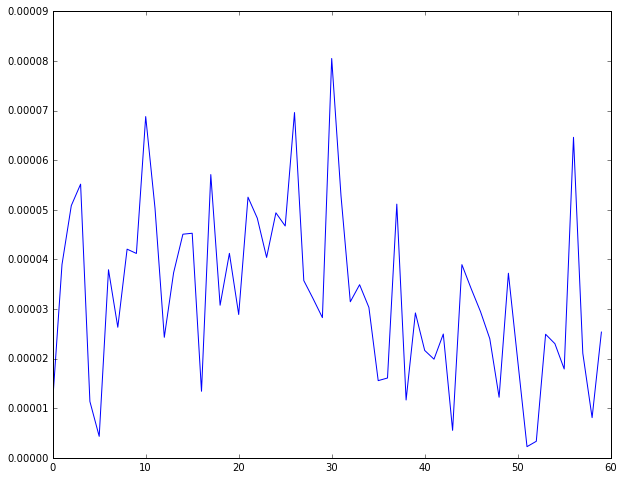

In [121]:
print("simulated")
plot(DTW_Self(x))

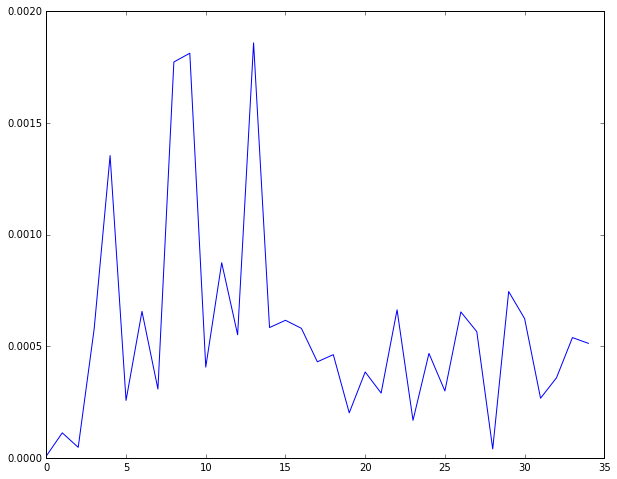

In [119]:
print('shake')
plot(DTW_Self(x))

human


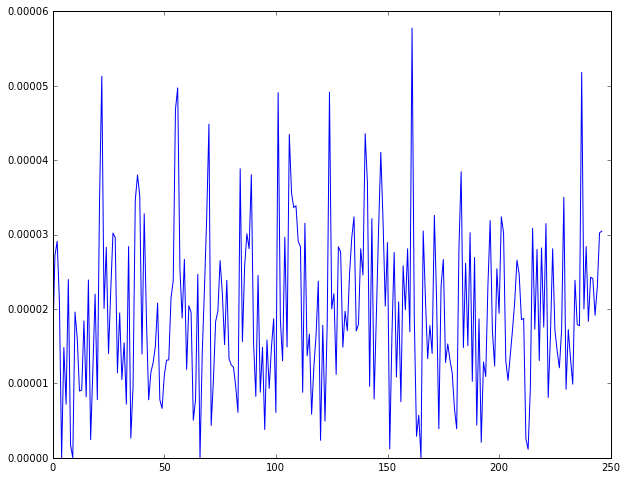

In [123]:
print("human")
plot(DTW_Self(x))